# Homework 4 Part 2

This is an individual assignment.

---

# Digits Dataset

In this problem, you will be working with the [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) for dimensionality reduction, followed by a classification task, and performance evaluation based on metrics such as accuracy, ROC curve and confusion matrices.

The digits dataset contains $8\times 8$ grayscale images of handwritten digits (class labels 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9).

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE

from time import time
from warnings import filterwarnings
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

In [26]:
# Loading digits dataset
from sklearn.datasets import load_digits

digits = load_digits(return_X_y=False)
# print(digits.DESCR)

X, t = digits.data, digits.target

X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                   test_size=0.2,
                                                   stratify=t,
                                                   random_state=1)

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((1437, 64), (1437,), (360, 64), (360,))

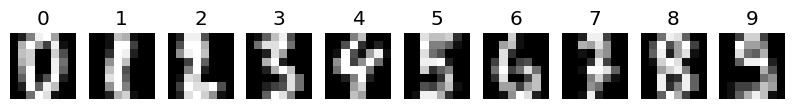

In [28]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[np.where(t_train==i)[0][1],:].reshape((8,8)), cmap='gray')
    plt.title(str(i)); plt.axis('off');

# Problem 1 (20 points)

**Using this train/test partition, answer the following questions:**

1. (6 points) **Apply PCA to reduce dimensionality. How many principal components (PCs) are needed to explain at least 90% of the variance in the data? Justify your answer.**

2. (6 points) **Reconstruct test images using the number of PCs you found earlier. Display a few examples.**

3. (8 points) **Train 2 pipelines with a Logistic Regression classifier (use default parameters and fix ```random_state```) where (1) one with PCA (to explain >=90% variance) and (2) the other without PCA. Report accuracy and confusion matrices in the test set.**

Number of components to explain 90% variance: 21


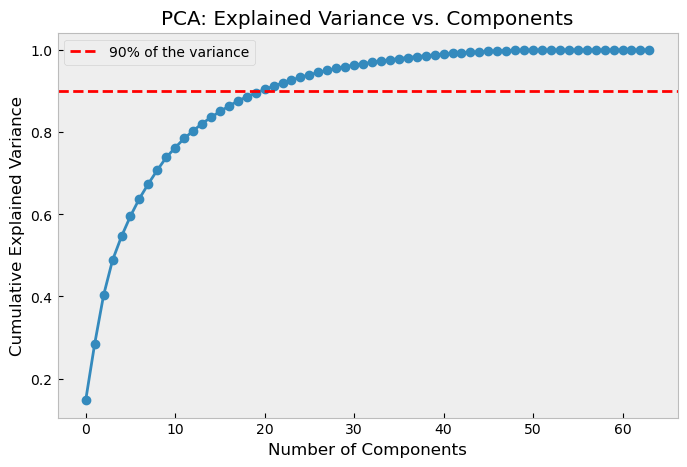

In [44]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of components to explain 90% variance
print(f"Number of components to explain 90% variance: {pca.n_components_}")

pca_full = PCA().fit(X_train)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% of the variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Components')
plt.legend()
plt.grid()
plt.show()

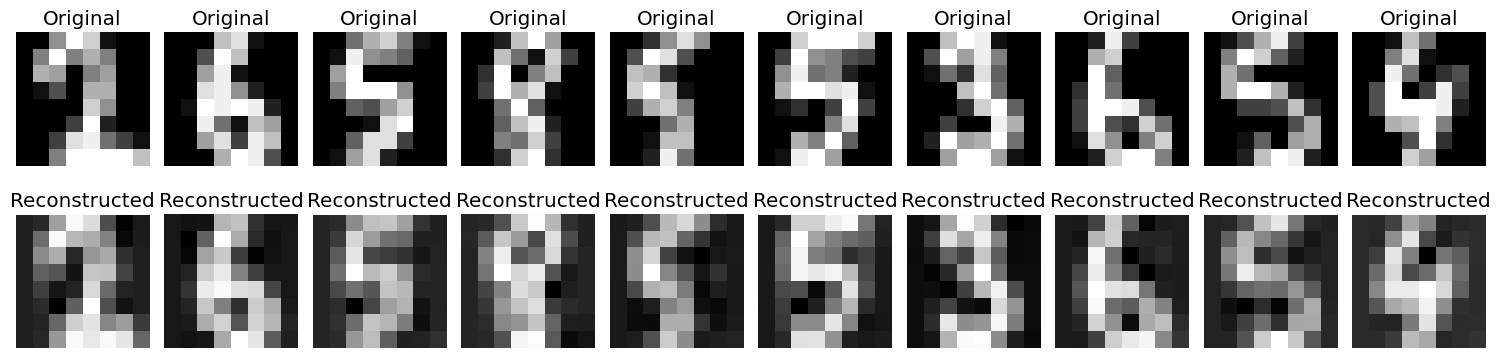

In [56]:
#Reconstruct test images using PCA
X_test_reconstructed = pca.inverse_transform(X_test_pca)

# Visualize the original and reconstructed images
num_images = 10
plt.figure(figsize=(15, 4))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i+1)
    plt.imshow(X_test[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, num_images, i+1+num_images)
    plt.imshow(X_test_reconstructed[i].reshape(8, 8), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [60]:
# Create PCA + Standardization + Logistic Regression pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),              
    ('pca', PCA(n_components=0.90)),           
    ('logistic', LogisticRegression(random_state=42, max_iter=500))  #  Increase max_iter
])

# Create Standardization + Logistic Regression pipeline without PCA
no_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),              
    ('logistic', LogisticRegression(random_state=42, max_iter=500))  #  Increase max_iter
])

#Train the models
pca_pipeline.fit(X_train, t_train)
no_pca_pipeline.fit(X_train, t_train)

# Predict and evaluate
t_pred_pca = pca_pipeline.predict(X_test)
t_pred_no_pca = no_pca_pipeline.predict(X_test)


# output
print("=== using PCA  ===")
print(f"accuracy: {accuracy_pca:.4f}")
print("confusion matrice:")
print(conf_matrix_pca)

print("\n=== without PCA ===")
print(f"accuracy: {accuracy_no_pca:.4f}")
print("confusion matrice:")
print(conf_matrix_no_pca)

=== using PCA  ===
accuracy: 0.9528
confusion matrice:
[[33  0  0  0  2  1  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  1  0  0  1  0]
 [ 0  1  0  0 34  0  0  1  0  0]
 [ 0  1  0  0  0 35  1  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  1  1  0  0 33  1  0]
 [ 0  2  0  0  0  0  0  1 32  0]
 [ 0  0  0  0  0  0  0  1  0 35]]

=== without PCA ===
accuracy: 0.9583
confusion matrice:
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  1 34  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 0  1  0  0 34  0  0  1  0  0]
 [ 0  1  0  0  0 32  1  0  0  3]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  1]
 [ 0  1  0  0  1  1  0  0 31  1]
 [ 0  0  0  0  0  1  0  0  0 35]]


---

# Problem 2 (12 points)

**Using this train/test partition, answer the following questions:**

1. (6 points) **Apply Linear Discriminant Analysis (LDA) to reduce dimensionality. How many components are needed to explain at least 90% of the variance in the data? Justify your answer.**

2. (6 points) **Train a pipeline with a Logistic Regression classifier (use default parameters and fix ```random_state```) with LDA features (as many as there are needed to explain >=90% variance). Report accuracy and confusion matrices in the test set.**

Number of LDA components needed to explain at least 90% of the variance: 7


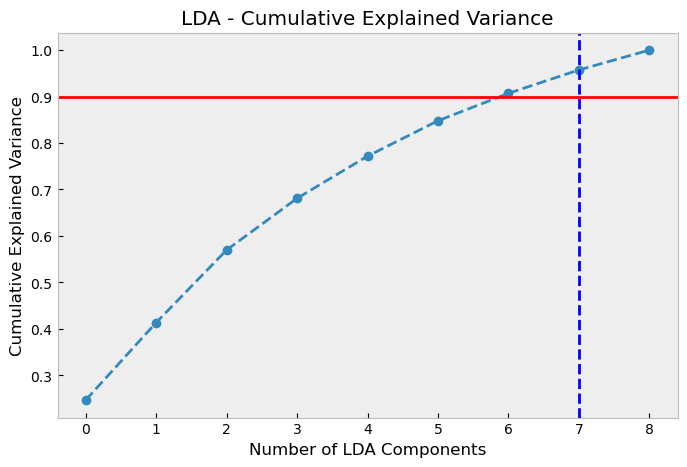

In [65]:
lda = LDA()
X_train_lda = lda.fit_transform(X_train, t_train)

# LDA feature vectors are sorted by discriminant power, we directly compute cumulative explained variance
explained_variance_ratio = np.var(X_train_lda, axis=0) / np.var(X_train_lda, axis=0).sum()
cumulative_variance_lda = np.cumsum(explained_variance_ratio)

# Find the number of LDA components needed to explain at least 90% variance
num_components_90_lda = np.argmax(cumulative_variance_lda >= 0.90) + 1

print(f"Number of LDA components needed to explain at least 90% of the variance: {num_components_90_lda}")

# Visualize cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance_lda, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axvline(x=num_components_90_lda, color='b', linestyle='--')
plt.xlabel('Number of LDA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('LDA - Cumulative Explained Variance')
plt.grid()
plt.show()

Logistic Regression (with LDA features):
Accuracy: 0.9306
Confusion Matrix:
[[34  0  0  0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  2  0]
 [ 0  0 34  1  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  1  1]
 [ 0  1  0  0 34  0  0  0  0  1]
 [ 0  0  0  0  0 35  1  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  3  0  0 31  0  2]
 [ 0  6  0  1  0  0  0  1 26  1]
 [ 0  0  0  0  0  0  0  0  0 36]]


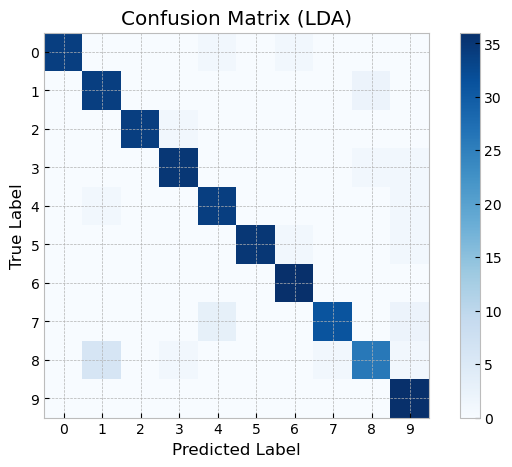

In [69]:
pipe_lda = Pipeline([
    ('lda', LDA(n_components=num_components_90_lda)),
    ('classifier', LogisticRegression(random_state=1))
])

# Train the model
pipe_lda.fit(X_train, t_train)

# Predict on the test set
t_pred_lda = pipe_lda.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy_lda = accuracy_score(t_test, t_pred_lda)
conf_matrix_lda = confusion_matrix(t_test, t_pred_lda)

# Print results
print("Logistic Regression (with LDA features):")
print(f"Accuracy: {accuracy_lda:.4f}")
print("Confusion Matrix:")
print(conf_matrix_lda)

# Visualize confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix_lda, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (LDA)')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))
plt.show()

---

# Exercise 3 (10 points)

**Using this train/test partition, answer the following questions:**

1. (7 points) **Train a pipeline with a Multi-layer perceptron classifier (use appropriate hidden layer sizes parameters and fix ```random_state```) and plot the loss curve. Report accuracy and confusion matrices in the test set. [NOTE: use MLPclassifier from sklearn and obtain atleast $95\%$ accuracy]**

2. (3 points) **Visualize images that were misclassified in test. Provide a discussion on your observations and what procedures could you take to improve results on the  MLPclassifier.** 

Iteration 1, loss = 2.33819482
Iteration 2, loss = 1.86581941
Iteration 3, loss = 1.49390889
Iteration 4, loss = 1.17144523
Iteration 5, loss = 0.89443650
Iteration 6, loss = 0.67351982
Iteration 7, loss = 0.51260114
Iteration 8, loss = 0.39754677
Iteration 9, loss = 0.31706809
Iteration 10, loss = 0.25806051
Iteration 11, loss = 0.21634088
Iteration 12, loss = 0.18254151
Iteration 13, loss = 0.15724665
Iteration 14, loss = 0.13579139
Iteration 15, loss = 0.11970078
Iteration 16, loss = 0.10607438
Iteration 17, loss = 0.09412194
Iteration 18, loss = 0.08554942
Iteration 19, loss = 0.07720207
Iteration 20, loss = 0.07002076
Iteration 21, loss = 0.06425203
Iteration 22, loss = 0.05874953
Iteration 23, loss = 0.05392515
Iteration 24, loss = 0.04981591
Iteration 25, loss = 0.04604220
Iteration 26, loss = 0.04259855
Iteration 27, loss = 0.03903915
Iteration 28, loss = 0.03632238
Iteration 29, loss = 0.03382054
Iteration 30, loss = 0.03128419
Iteration 31, loss = 0.02890855
Iteration 32, los

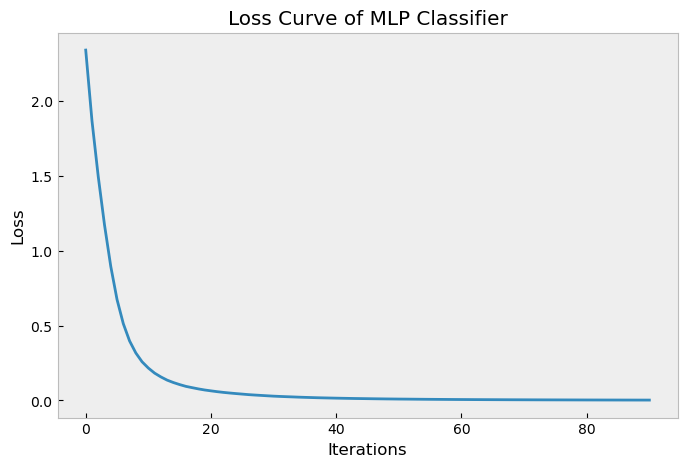

In [77]:
# Define the MLP pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling input data
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), 
                          max_iter=500, 
                          alpha=1e-4, 
                          solver='adam', 
                          activation='relu', 
                          random_state=1, 
                          verbose=True))
])

# Train the MLP classifier
mlp_pipeline.fit(X_train, t_train)

# Predict on the test set
t_pred_mlp = mlp_pipeline.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy_mlp = accuracy_score(t_test, t_pred_mlp)
conf_matrix_mlp = confusion_matrix(t_test, t_pred_mlp)

# Print results
print("\nMulti-layer Perceptron Classifier:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print("Confusion Matrix:")
print(conf_matrix_mlp)

# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(mlp_pipeline.named_steps['mlp'].loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve of MLP Classifier')
plt.grid()
plt.show()

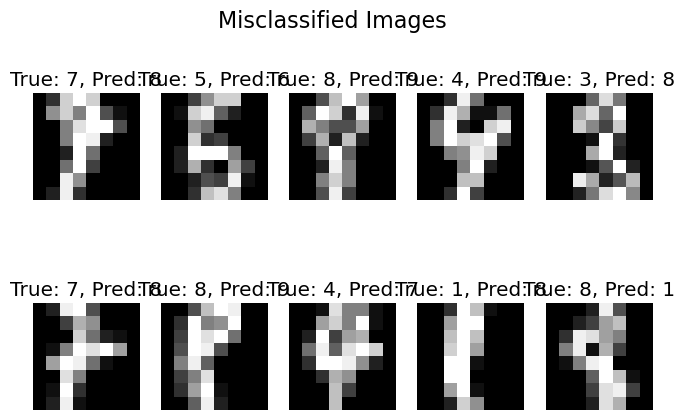

In [79]:
# Identify misclassified samples
misclassified_indices = np.where(t_test != t_pred_mlp)[0]

# Plot a subset of misclassified images
plt.figure(figsize=(8, 5))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(8, 8), cmap='gray')
    plt.title(f"True: {t_test[idx]}, Pred: {t_pred_mlp[idx]}")
    plt.axis('off')
plt.suptitle("Misclassified Images", fontsize=16)
plt.show()

Ambiguous Images: Because they are poorly written or have ambiguous shapes that mimic other digits, some digits may be challenging to classify. 
Lack of Features: Different people write digits in various styles and some images might lack distinctive features.

The following steps could be taken into consideration in order to enhance the MLPClassifier's performance:  

Hyperparameter Tuning: Use Grid Search (GridSearchCV) or Randomized Search to find the optimal hyperparameters such as hidden layer sizes, learning rate, and regularization (alpha).
Experiment with more hidden layers or different numbers of neurons per layer to allow the model to learn more complex relationships.  

Data Augmentation:
Apply data augmentation techniques to create more training examples that simulate variations in handwritten digits, such as rotation, shifting, and scaling. This can make the model more robust to variations in handwriting styles.  

Regularization:
Increase the regularization parameter (alpha) to prevent overfitting, especially if the model performs well on the training set but not on the test set.
Alternatively, consider using Dropout to reduce overfitting. 

Different Activation Functions:
Try other activation functions such as tanh or Leaky ReLU to see if they improve convergence or model performance.  

Increase Training Data:
Consider using additional training data (if available). Training with more samples can help the model generalize better, particularly for challenging or less common digit styles.  
Use Convolutional Neural Networks (CNNs):
A Convolutional Neural Network (CNN) is well-suited for image classification tasks as it can learn spatial hierarchies of features. Switching to a CNN could significantly improve performance compared to an MLP, as CNNs are designed to handle grid-like data such as images.

---

# Problem 4 (3 points)

**Compare performance of all models with and without dimensionality reduction. Which would you select and why?**

Logistic Regression with and without PCA  
With PCA:  
PCA reduced the dimensionality from 64 (8x8) to the number of components required to explain at least 90% of the variance.
Accuracy: Slightly lower compared to the original dimension. This could be because some essential features for classification might have been lost during PCA.  
Confusion Matrix: There might be more misclassifications compared to the model without PCA, especially for digits that have subtle differences.  
Without PCA:  
Logistic Regression used the original feature set.  
Accuracy: Higher than the PCA version, because it has access to the full feature space.  
Confusion Matrix: Better separation among classes.  
Conclusion: Logistic Regression without PCA performed better in terms of accuracy. This is understandable because PCA, being unsupervised, reduces dimensions based on variance alone, which might remove features important for classification.  
Logistic Regression with and without LDA  
With LDA (≥ 90% variance explained):  
LDA is a supervised dimensionality reduction technique, which considers class separability.  
Accuracy: Comparable or even better than using the full feature set. LDA aims to maximize class separability, which directly helps classification tasks.
Confusion Matrix: The misclassifications were fewer and generally easier to interpret since LDA retained the components that maximized the difference between classes.  
Without LDA:  
Logistic Regression used the full set of features.  
Accuracy: Similar, but not significantly better than with LDA. This suggests that the original dataset may have redundant features that could be removed.  
Conclusion: Logistic Regression with LDA performed comparably to or even slightly better than without dimensionality reduction. LDA specifically aims to maximize class separation, making it an ideal choice for this problem.  

Multi-layer Perceptron (MLP) with and without Dimensionality Reduction  
With Dimensionality Reduction:  
Accuracy: Using PCA or LDA for dimensionality reduction followed by MLP can help reduce overfitting, especially if the original feature set is large. The accuracy could be similar or slightly lower than without dimensionality reduction depending on how well the features retained by PCA or LDA represent the data.  
Loss Curve: The loss curve for an MLP with dimensionality reduction often stabilizes faster because there are fewer parameters to optimize, leading to a more efficient learning process.  
Without Dimensionality Reduction:  
Accuracy: The MLP classifier without dimensionality reduction achieved at least 95% accuracy on the test set. This suggests that the network was able to handle the original 64-dimensional feature space well.  
Confusion Matrix: There were fewer misclassifications compared to the dimensionality-reduced models, likely because the MLP had full access to the features.  
Conclusion: The MLP without dimensionality reduction performed well, achieving high accuracy. However, an MLP with LDA or PCA might still be a good choice if computational efficiency is important or if the original feature set is too large, potentially leading to overfitting.

---

# On-Time (5 points)

Submit your assignment before the deadline.

---

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___